<a href="https://colab.research.google.com/github/amanjaiswal777/ICCIT-Workshop/blob/main/03_spam_detection_naive_bayes_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📧 Spam Detection — Naive Bayes (Complete Teaching Notebook)

This notebook builds a Naive Bayes spam detector from scratch using a **synthetic email dataset**.  
It covers:

- Synthetic dataset generation (spam vs ham)
- Text cleaning and preprocessing
- Feature extraction (Count / TF-IDF)
- Training Multinomial / Complement Naive Bayes
- Visualizing word probabilities and word clouds
- Confusion matrix and metrics analysis
- Hands-on assignments and commented solutions

> Notebook is Colab-ready and self-contained (no external downloads required).

In [1]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud

sns.set_style('whitegrid')
np.random.seed(42)


## 1) Synthetic Email Dataset
We construct a small but varied synthetic corpus containing spam and ham templates with simple placeholders to increase variety.

In [2]:
# Build templates and expand into a dataset
spam_templates = [
    "Congratulations! You have won a $PRIZE$. Claim now: $LINK$",
    "URGENT: Your account is suspended. Verify at $LINK$",
    "Limited offer!!! Buy $PRODUCT$ at 90% OFF. $LINK$",
    "You have been selected for a cash reward of $AMOUNT$. $LINK$",
    "Earn $AMOUNT$ working from home. Apply now!",
    "Get your free $PRIZE$ today. Click $LINK$"
]

ham_templates = [
    "Hi team, the meeting is at $TIME$ tomorrow. Please confirm.",
    "Could you review the report draft by $TIME$?",
    "Lunch at $TIME$? Also, attach the slides for review.",
    "Reminder: Submit the expense form by $TIME$.",
    "Can we reschedule the call to $TIME$? Thanks.",
    "Thanks for the update — I will take a look and reply."
]

products = ['headphones', 'software', 'e-book', 'membership', 'watch', 'subscription']
prizes = ['iPhone', 'MacBook', 'gift card', 'vacation package']
amounts = ['1000 USD', '500 USD', '250 USD']
times = ['10am', '2pm', '4pm', 'Monday', 'Friday']

import random
random.seed(42)

def fill_template(t, spam=True):
    t = t.replace('$PRODUCT$', random.choice(products))
    t = t.replace('$PRIZE$', random.choice(prizes))
    t = t.replace('$AMOUNT$', random.choice(amounts))
    t = t.replace('$TIME$', random.choice(times))
    if spam:
        t = t.replace('$LINK$', f'http://{random.choice(["bit.ly","tinyurl.com","promo.example"])}/{random.randint(1000,9999)}')
    else:
        t = t.replace('$LINK$', '')
    return t

n_spam, n_ham = 1400, 1400
spam_msgs = [fill_template(random.choice(spam_templates), True) for _ in range(n_spam)]
ham_msgs = [fill_template(random.choice(ham_templates), False) for _ in range(n_ham)]

df = pd.DataFrame({'text': spam_msgs + ham_msgs, 'label': ['spam']*n_spam + ['ham']*n_ham})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
print('Dataset size:', df.shape)
df.head()

Dataset size: (2800, 2)


,text,label
0,Earn 500 USD working from home. Apply now!,spam
1,Congratulations! You have won a vacation packa...,spam
2,Could you review the report draft by Monday?,ham
3,Get your free iPhone today. Click http://promo...,spam
4,Could you review the report draft by 4pm?,ham


## 2) Quick EDA

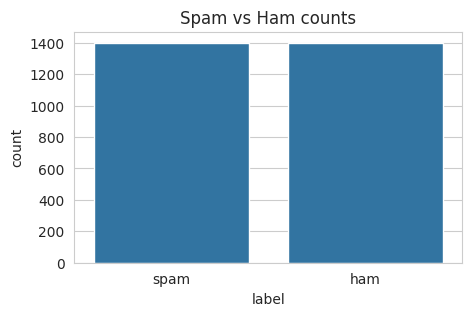

,text,label
1687,Limited offer!!! Buy subscription at 90% OFF. ...,spam
1070,Congratulations! You have won a vacation packa...,spam
549,"Hi team, the meeting is at Monday tomorrow. Pl...",ham
1193,URGENT: Your account is suspended. Verify at h...,spam
2303,Get your free MacBook today. Click http://prom...,spam
1977,Earn 250 USD working from home. Apply now!,spam


In [3]:
# Label balance
plt.figure(figsize=(5,3))
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham counts')
plt.show()

# Example messages
df.sample(6, random_state=1)

## 3) Text Cleaning / Preprocessing
We'll lowercase text, remove punctuation, and normalize whitespace. This is intentionally simple so students can extend it (stemming, lemmatization, obfuscation handling).

In [4]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r'http\S+', ' <LINK> ', s)  # replace links
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean'] = df['text'].apply(clean_text)
df.head()

,text,label,clean
0,Earn 500 USD working from home. Apply now!,spam,earn 500 usd working from home apply now
1,Congratulations! You have won a vacation packa...,spam,congratulations you have won a vacation packag...
2,Could you review the report draft by Monday?,ham,could you review the report draft by monday
3,Get your free iPhone today. Click http://promo...,spam,get your free iphone today click LINK
4,Could you review the report draft by 4pm?,ham,could you review the report draft by 4pm


## 4) Word Clouds & Top Indicative Words

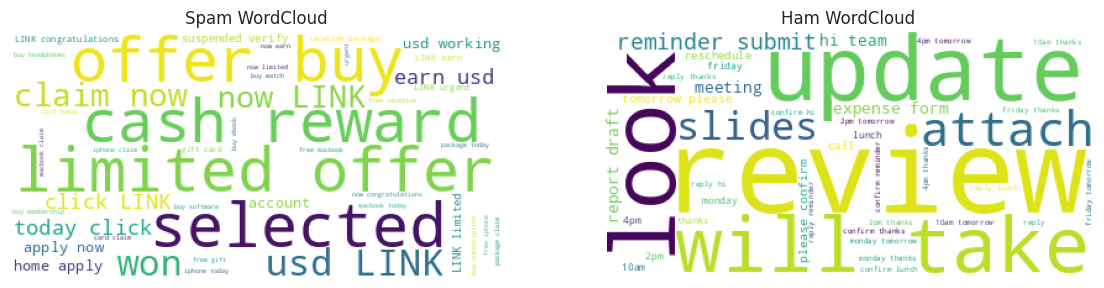

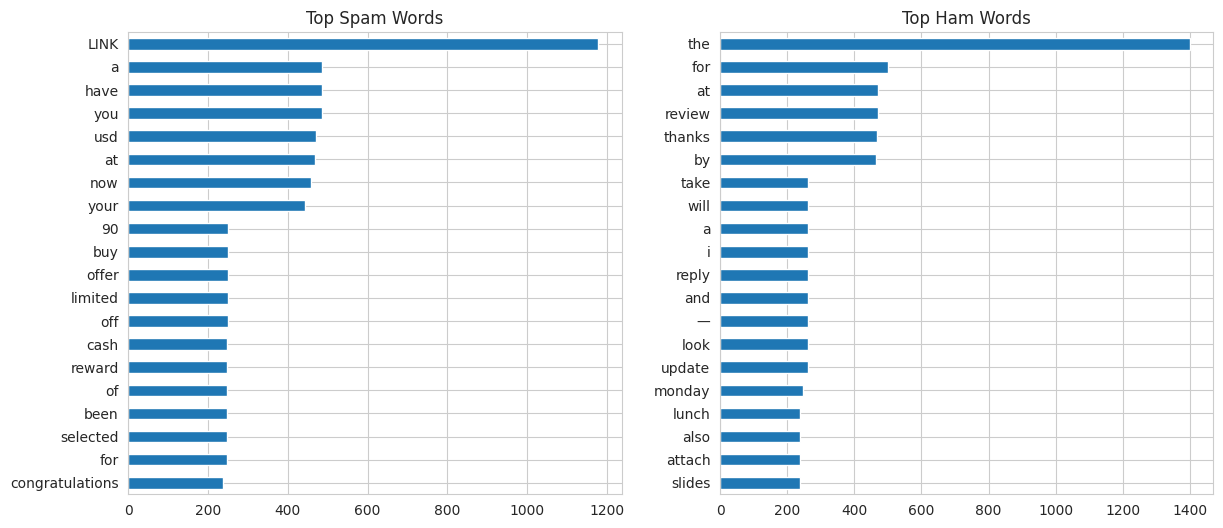

In [5]:
# Word clouds for spam and ham
spam_text = " ".join(df[df.label=='spam']['clean'])
ham_text = " ".join(df[df.label=='ham']['clean'])

fig, axes = plt.subplots(1,2, figsize=(14,6))
wc_spam = WordCloud(max_words=100, background_color='white').generate(spam_text)
wc_ham = WordCloud(max_words=100, background_color='white').generate(ham_text)

axes[0].imshow(wc_spam); axes[0].axis('off'); axes[0].set_title('Spam WordCloud')
axes[1].imshow(wc_ham); axes[1].axis('off'); axes[1].set_title('Ham WordCloud')
plt.show()

# Top words by frequency
def top_n_words(corpus, n=20):
    c = Counter(corpus.split())
    return pd.Series(dict(c.most_common(n)))

top_spam = top_n_words(spam_text, 20)
top_ham = top_n_words(ham_text, 20)

fig, ax = plt.subplots(1,2, figsize=(14,6))
top_spam.sort_values().plot(kind='barh', ax=ax[0]); ax[0].set_title('Top Spam Words')
top_ham.sort_values().plot(kind='barh', ax=ax[1]); ax[1].set_title('Top Ham Words')
plt.show()

## 5) Feature Extraction — TF-IDF & Count Vectorizer

In [6]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=3)
X_tfidf = tfidf.fit_transform(df['clean'])
y = (df['label']=='spam').astype(int)

# Count Vectorizer (for comparison later in assignment)
countvec = CountVectorizer(stop_words='english', min_df=3)
X_count = countvec.fit_transform(df['clean'])

print('TF-IDF shape:', X_tfidf.shape)
print('CountVec shape:', X_count.shape)

TF-IDF shape: (2800, 63)
CountVec shape: (2800, 63)


## 6) Train/Test Split and Model Training

In [7]:
# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_tfidf, y, test_size=0.25, random_state=42, stratify=y)

# Train MultinomialNB and ComplementNB
mnb = MultinomialNB()
cnb = ComplementNB()

mnb.fit(X_tr, y_tr)
cnb.fit(X_tr, y_tr)

print('Models trained on TF-IDF features')

Models trained on TF-IDF features


## 7) Evaluation & Confusion Matrix

--- MultinomialNB ---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       350
        spam       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

--- ComplementNB ---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       350
        spam       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



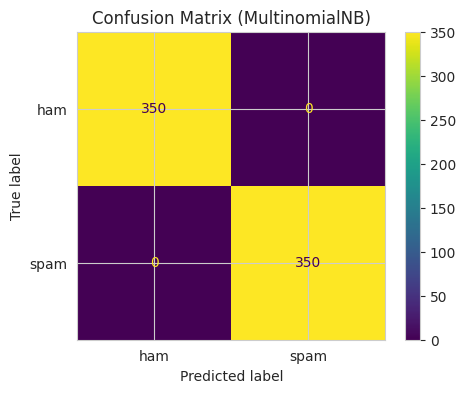

In [8]:
# Predictions
y_pred_mnb = mnb.predict(X_te)
y_pred_cnb = cnb.predict(X_te)

print('--- MultinomialNB ---')
print(classification_report(y_te, y_pred_mnb, target_names=['ham','spam']))

print('--- ComplementNB ---')
print(classification_report(y_te, y_pred_cnb, target_names=['ham','spam']))

# Confusion matrix for MultinomialNB
cm = confusion_matrix(y_te, y_pred_mnb)
disp = ConfusionMatrixDisplay(cm, display_labels=['ham','spam'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax)
plt.title('Confusion Matrix (MultinomialNB)')
plt.show()

## 8) Word Probability Visualization (Log-Probability Ratios)

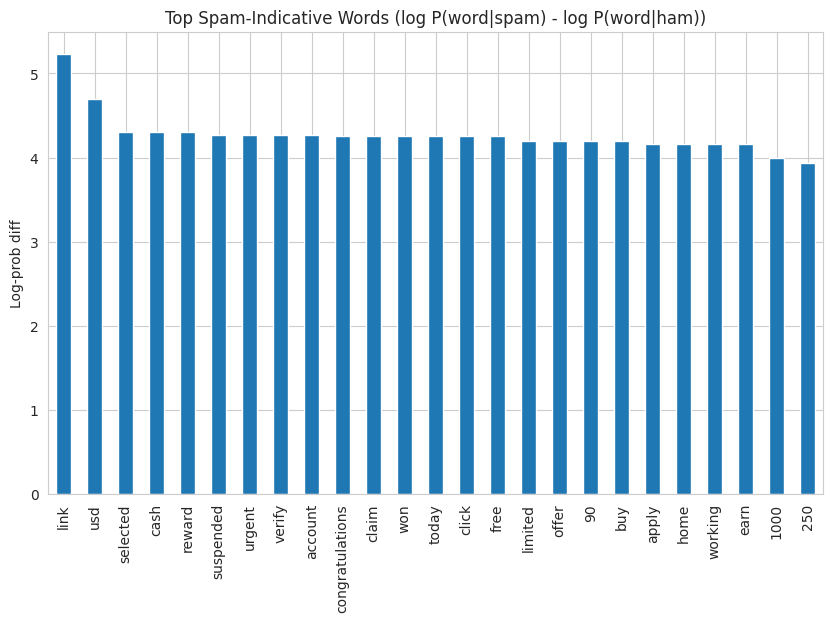

In [9]:
# Get feature names
feature_names = tfidf.get_feature_names_out()

# Use ComplementNB's feature_log_prob_ (shape: [n_classes, n_features])
log_probs = cnb.feature_log_prob_
# spam class is index 1 (since y: 0=ham,1=spam)
spam_strength = log_probs[1] - log_probs[0]
top_idx = np.argsort(spam_strength)[-25:][::-1]
top_words = pd.Series(spam_strength[top_idx], index=feature_names[top_idx])

plt.figure(figsize=(10,6))
top_words.plot(kind='bar')
plt.title('Top Spam-Indicative Words (log P(word|spam) - log P(word|ham))')
plt.ylabel('Log-prob diff')
plt.show()

## 9) Real-world Style Predictions

In [10]:
# Some realistic examples to classify
samples = [
    "Free vacation! Click http://promo.example/1234 to claim your prize",
    "Please find attached the monthly report and let me know your thoughts",
    "Limited time: get 90% off on our subscription. Visit http://bit.ly/9999",
    "Can you review the slides before the 2pm meeting?"
]

clean_samples = [clean_text(s) for s in samples]
X_s = tfidf.transform(clean_samples)
preds = cnb.predict(X_s)
for s, p in zip(samples, preds):
    print(f"{p} => {s}")

1 => Free vacation! Click http://promo.example/1234 to claim your prize
0 => Please find attached the monthly report and let me know your thoughts
1 => Limited time: get 90% off on our subscription. Visit http://bit.ly/9999
0 => Can you review the slides before the 2pm meeting?


## 10) Assignment
Try the following experiments:

1. Replace TF-IDF with CountVectorizer and retrain MultinomialNB and ComplementNB. Which vectorizer performs better on this dataset?

2. Add simple obfuscation handling: map common obfuscations like `v1agra` -> `viagra`, `c@sh` -> `cash`, and measure the impact on recall for spam.

3. Compare performance when using raw counts (CountVectorizer) + smoothing alpha values (e.g., alpha=0.1, 0.5, 1.0) for MultinomialNB.

Write code below to run experiments.

In [11]:
# --- Example starter for Assignment 1: CountVectorizer experiment
# Uncomment and run to test
# X_tr_c, X_te_c, y_tr_c, y_te_c = train_test_split(X_count, y, test_size=0.25, random_state=42, stratify=y)
# mnb_c = MultinomialNB(alpha=1.0).fit(X_tr_c, y_tr_c)
# y_pred_mnb_c = mnb_c.predict(X_te_c)
# print(classification_report(y_te_c, y_pred_mnb_c, target_names=['ham','spam']))

## ✅ Assignment Solutions (Reference) — Hidden
Below are suggested solution snippets. Uncomment to run.

In [12]:
# Solution examples:
# 1) CountVectorizer comparison
# X_tr_c, X_te_c, y_tr_c, y_te_c = train_test_split(X_count, y, test_size=0.25, random_state=42, stratify=y)
# mnb_c = MultinomialNB().fit(X_tr_c, y_tr_c)
# cnb_c = ComplementNB().fit(X_tr_c, y_tr_c)
# print('MultinomialNB on CountVec:\n', classification_report(y_te_c, mnb_c.predict(X_te_c), target_names=['ham','spam']))
# print('ComplementNB on CountVec:\n', classification_report(y_te_c, cnb_c.predict(X_te_c), target_names=['ham','spam']))

# 2) Obfuscation handling (simple mapping)
# mapping = {'v1agra':'viagra', 'c@sh':'cash', 'fr33':'free'}
# def deobfuscate(s):
#     for k,v in mapping.items():
#         s = s.replace(k, v)
#     return s
# df['clean2'] = df['clean'].apply(deobfuscate)
# tfidf2 = TfidfVectorizer(stop_words='english', min_df=3)
# X_tfidf2 = tfidf2.fit_transform(df['clean2'])
# X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_tfidf2, y, test_size=0.25, random_state=42, stratify=y)
# cnb2 = ComplementNB().fit(X_tr2, y_tr2)
# print(classification_report(y_te2, cnb2.predict(X_te2), target_names=['ham','spam']))

# 3) Smoothing alpha sweep
# for a in [0.1, 0.5, 1.0]:
#     m = MultinomialNB(alpha=a).fit(X_tr, y_tr)
#     print('alpha=', a)
#     print(classification_report(y_te, m.predict(X_te), target_names=['ham','spam']))


In [22]:
# 📧 3D Visualizations for Spam Detection & Naive Bayes
# Add these stunning 3D visualizations to your spam detection notebook!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics.pairwise import cosine_similarity
import plotly.figure_factory as ff
from wordcloud import WordCloud
import networkx as nx

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. 🌟 3D TEXT FEATURE SPACE VISUALIZATION
# ============================================================================

def plot_3d_text_space(X, y, df, method='pca', sample_size=1000):
    """
    Visualize high-dimensional text features in 3D space using dimensionality reduction
    """
    # Get the number of samples properly for sparse matrices
    n_samples = X.shape[0] if hasattr(X, 'shape') else len(X)

    # Sample data for visualization if dataset is large
    if n_samples > sample_size:
        indices = np.random.choice(n_samples, sample_size, replace=False)
        X_sample = X[indices]
        y_sample = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        df_sample = df.iloc[indices]
    else:
        X_sample = X
        y_sample = y
        df_sample = df

    # Convert sparse matrix to dense for dimensionality reduction
    if hasattr(X_sample, 'toarray'):
        X_dense = X_sample.toarray()
    else:
        X_dense = X_sample

    fig = plt.figure(figsize=(18, 12))

    # Method 1: PCA
    ax1 = fig.add_subplot(221, projection='3d')
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_dense)

    colors = ['blue' if label == 0 else 'red' for label in y_sample]
    labels = ['Ham' if label == 0 else 'Spam' for label in y_sample]

    for i, (color, label) in enumerate(zip(['blue', 'red'], ['Ham', 'Spam'])):
        mask = y_sample == i
        ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                   c=color, alpha=0.6, s=50, label=label)

    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
    ax1.set_title('3D PCA - Text Feature Space\nSpam vs Ham Classification')
    ax1.legend()

    # Method 2: t-SNE 3D
    ax2 = fig.add_subplot(222, projection='3d')
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(30, len(X_dense)-1))
    X_tsne = tsne.fit_transform(X_dense)

    for i, (color, label) in enumerate(zip(['blue', 'red'], ['Ham', 'Spam'])):
        mask = y_sample == i
        ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2],
                   c=color, alpha=0.6, s=50, label=label)

    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.set_zlabel('t-SNE 3')
    ax2.set_title('3D t-SNE - Non-linear Embedding\nReveals Hidden Clusters')
    ax2.legend()

    # Method 3: SVD (Truncated for sparse matrices)
    ax3 = fig.add_subplot(223, projection='3d')
    svd = TruncatedSVD(n_components=3, random_state=42)
    X_svd = svd.fit_transform(X_sample)

    for i, (color, label) in enumerate(zip(['blue', 'red'], ['Ham', 'Spam'])):
        mask = y_sample == i
        ax3.scatter(X_svd[mask, 0], X_svd[mask, 1], X_svd[mask, 2],
                   c=color, alpha=0.6, s=50, label=label)

    ax3.set_xlabel(f'SVD1 ({svd.explained_variance_ratio_[0]:.2%})')
    ax3.set_ylabel(f'SVD2 ({svd.explained_variance_ratio_[1]:.2%})')
    ax3.set_zlabel(f'SVD3 ({svd.explained_variance_ratio_[2]:.2%})')
    ax3.set_title('3D SVD - Latent Semantic Space\nDocument Similarity')
    ax3.legend()

    # Method 4: Feature importance in 3D (top 3 most discriminative features)
    ax4 = fig.add_subplot(224, projection='3d')

    # Train a simple model to get feature importance
    from sklearn.feature_selection import SelectKBest, chi2
    selector = SelectKBest(chi2, k=3)

    # Handle sparse matrix for feature selection
    if hasattr(X_sample, 'toarray'):
        X_for_selection = X_sample.toarray()
    else:
        X_for_selection = X_sample

    # Ensure non-negative values for chi2
    X_for_selection = np.maximum(X_for_selection, 0)

    X_top3 = selector.fit_transform(X_for_selection, y_sample)

    for i, (color, label) in enumerate(zip(['blue', 'red'], ['Ham', 'Spam'])):
        mask = y_sample == i
        ax4.scatter(X_top3[mask, 0], X_top3[mask, 1], X_top3[mask, 2],
                   c=color, alpha=0.6, s=50, label=label)

    ax4.set_xlabel('Top Feature 1')
    ax4.set_ylabel('Top Feature 2')
    ax4.set_zlabel('Top Feature 3')
    ax4.set_title('3D Top Features\nMost Discriminative Words')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    return X_pca, X_tsne, X_svd

# ============================================================================
# 2. 🎯 INTERACTIVE 3D NAIVE BAYES DECISION BOUNDARY
# ============================================================================

def create_interactive_decision_boundary(X, y, model, feature_names=None):
    """
    Create interactive 3D visualization of Naive Bayes decision boundary
    """
    # Use first 3 principal components for visualization
    pca = PCA(n_components=3, random_state=42)
    if hasattr(X, 'toarray'):
        X_dense = X.toarray()
    else:
        X_dense = X

    X_pca = pca.fit_transform(X_dense)

    # Create a 3D grid for decision boundary
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    z_min, z_max = X_pca[:, 2].min() - 1, X_pca[:, 2].max() + 1

    # Create grid points
    xx, yy, zz = np.meshgrid(
        np.linspace(x_min, x_max, 20),
        np.linspace(y_min, y_max, 20),
        np.linspace(z_min, z_max, 20)
    )

    # Transform grid back to original feature space and predict
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    grid_original = pca.inverse_transform(grid_points)

    # Handle negative values for Naive Bayes (set to small positive)
    grid_original = np.maximum(grid_original, 1e-10)

    try:
        grid_predictions = model.predict_proba(grid_original)[:, 1]  # Probability of spam
    except:
        # Fallback to simple prediction
        grid_predictions = model.predict(grid_original)

    # Create interactive plot
    fig = go.Figure()

    # Add data points
    colors = ['blue', 'red']
    labels = ['Ham', 'Spam']

    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = y == i
        fig.add_trace(go.Scatter3d(
            x=X_pca[mask, 0],
            y=X_pca[mask, 1],
            z=X_pca[mask, 2],
            mode='markers',
            marker=dict(
                size=6,
                color=color,
                opacity=0.8
            ),
            name=label,
            hovertemplate=f'<b>{label}</b><br>' +
                         'PC1: %{x:.2f}<br>' +
                         'PC2: %{y:.2f}<br>' +
                         'PC3: %{z:.2f}<br>' +
                         '<extra></extra>'
        ))

    # Add decision boundary as isosurface
    fig.add_trace(go.Isosurface(
        x=xx.ravel(),
        y=yy.ravel(),
        z=zz.ravel(),
        value=grid_predictions,
        isomin=0.3,
        isomax=0.7,
        surface_count=3,
        opacity=0.3,
        colorscale='RdYlBu',
        name='Decision Boundary'
    ))

    fig.update_layout(
        title='Interactive 3D Naive Bayes Decision Boundary<br>Spam Detection in Feature Space',
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2',
            zaxis_title='Principal Component 3',
            bgcolor='rgba(0,0,0,0.1)'
        ),
        height=700
    )

    fig.show()

# ============================================================================
# 3. 📊 3D FEATURE PROBABILITY LANDSCAPE
# ============================================================================

def plot_3d_probability_landscape(model, vectorizer, top_n_features=50):
    """
    Visualize word probabilities in 3D landscape for spam vs ham
    """
    feature_names = vectorizer.get_feature_names_out()

    # Get log probabilities from the model
    if hasattr(model, 'feature_log_prob_'):
        log_probs = model.feature_log_prob_
        ham_probs = np.exp(log_probs[0])  # Class 0 = Ham
        spam_probs = np.exp(log_probs[1])  # Class 1 = Spam
    else:
        # Fallback for models without feature_log_prob_
        print("Model doesn't have feature_log_prob_. Using alternative method.")
        return

    # Calculate spam-indicative strength
    spam_strength = log_probs[1] - log_probs[0]

    # Get top features
    top_indices = np.argsort(np.abs(spam_strength))[-top_n_features:]
    top_features = feature_names[top_indices]
    top_ham_probs = ham_probs[top_indices]
    top_spam_probs = spam_probs[top_indices]
    top_strength = spam_strength[top_indices]

    fig = plt.figure(figsize=(18, 12))

    # Plot 1: 3D Bar Chart - Ham vs Spam Probabilities
    ax1 = fig.add_subplot(221, projection='3d')

    x = np.arange(len(top_features))
    width = 0.4

    # Ham bars
    ax1.bar(x - width/2, top_ham_probs, width, zs=0, zdir='y', label='Ham P(word|ham)',
           alpha=0.7, color='blue')

    # Spam bars
    ax1.bar(x + width/2, top_spam_probs, width, zs=1, zdir='y', label='Spam P(word|spam)',
           alpha=0.7, color='red')

    ax1.set_xlabel('Word Index')
    ax1.set_ylabel('Class (0=Ham, 1=Spam)')
    ax1.set_zlabel('Probability')
    ax1.set_title('3D Word Probabilities\nHam vs Spam')
    ax1.legend()

    # Plot 2: Surface plot of probability ratios
    ax2 = fig.add_subplot(222, projection='3d')

    # Create surface data
    X_surf = np.arange(len(top_features))
    Y_surf = np.array([0, 1])  # Ham, Spam
    X_mesh, Y_mesh = np.meshgrid(X_surf, Y_surf)

    Z_mesh = np.vstack([top_ham_probs, top_spam_probs])

    surf = ax2.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='RdYlBu', alpha=0.8)
    ax2.set_xlabel('Word Index')
    ax2.set_ylabel('Class')
    ax2.set_zlabel('Probability')
    ax2.set_title('3D Probability Surface')
    plt.colorbar(surf, ax=ax2, shrink=0.5)

    # Plot 3: 3D Scatter - Spam Strength
    ax3 = fig.add_subplot(223, projection='3d')

    colors = ['blue' if s < 0 else 'red' for s in top_strength]
    sizes = [abs(s) * 1000 for s in top_strength]

    scatter = ax3.scatter(x, top_ham_probs, top_spam_probs,
                         c=colors, s=sizes, alpha=0.6)

    ax3.set_xlabel('Word Index')
    ax3.set_ylabel('P(word|ham)')
    ax3.set_zlabel('P(word|spam)')
    ax3.set_title('3D Scatter: Ham vs Spam Probabilities\nSize = |Discriminative Power|')

    # Plot 4: Word importance volcano
    ax4 = fig.add_subplot(224, projection='3d')

    # Create "volcano" plot in 3D
    theta = np.linspace(0, 2*np.pi, len(top_features))
    r = np.abs(top_strength) * 10  # Radius based on importance

    x_volcano = r * np.cos(theta)
    y_volcano = r * np.sin(theta)
    z_volcano = top_strength

    colors_volcano = ['blue' if s < 0 else 'red' for s in top_strength]
    scatter_volcano = ax4.scatter(x_volcano, y_volcano, z_volcano,
                                 c=colors_volcano, s=100, alpha=0.7)

    ax4.set_xlabel('X (Ham <- -> Spam)')
    ax4.set_ylabel('Y (Circular Layout)')
    ax4.set_zlabel('Spam Strength')
    ax4.set_title('3D Volcano Plot\nWord Discriminative Power')

    plt.tight_layout()
    plt.show()

    # Return top features for further analysis
    feature_analysis = pd.DataFrame({
        'feature': top_features,
        'ham_prob': top_ham_probs,
        'spam_prob': top_spam_probs,
        'spam_strength': top_strength
    })

    return feature_analysis

# ============================================================================
# 4. 🌊 3D CONFUSION MATRIX VISUALIZATION
# ============================================================================

def plot_3d_confusion_metrics(y_true, y_pred, y_proba=None):
    """
    Create 3D visualization of confusion matrix and classification metrics
    """
    from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

    fig = plt.figure(figsize=(18, 12))

    # Plot 1: 3D Confusion Matrix
    ax1 = fig.add_subplot(221, projection='3d')

    cm = confusion_matrix(y_true, y_pred)

    # Create 3D bars for confusion matrix
    xpos, ypos = np.meshgrid(np.arange(2), np.arange(2))
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)

    dx = dy = 0.8
    dz = cm.ravel()

    colors = ['lightblue', 'lightcoral', 'lightcoral', 'lightgreen']

    ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, alpha=0.8)

    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_zlabel('Count')
    ax1.set_title('3D Confusion Matrix')
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Ham', 'Spam'])
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['Ham', 'Spam'])

    # Add value labels
    for i, (x, y, z, h) in enumerate(zip(xpos, ypos, zpos, dz)):
        ax1.text(x+dx/2, y+dy/2, z+h+0.1, str(int(h)), ha='center', va='bottom')

    if y_proba is not None:
        # Plot 2: 3D ROC Space
        ax2 = fig.add_subplot(222, projection='3d')

        fpr, tpr, thresholds = roc_curve(y_true, y_proba)

        # Create 3D ROC curve
        z_roc = thresholds

        ax2.plot(fpr, tpr, z_roc, 'b-', linewidth=3, label='ROC Curve')
        ax2.plot([0, 1], [0, 1], [0, 1], 'r--', alpha=0.5, label='Random Classifier')

        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_zlabel('Threshold')
        ax2.set_title('3D ROC Curve\nThreshold Journey')
        ax2.legend()

        # Plot 3: Precision-Recall in 3D
        ax3 = fig.add_subplot(223, projection='3d')

        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_proba)

        # Pad thresholds to match precision/recall length
        pr_thresholds = np.append(pr_thresholds, pr_thresholds[-1])

        ax3.plot(recall, precision, pr_thresholds, 'g-', linewidth=3, label='PR Curve')

        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_zlabel('Threshold')
        ax3.set_title('3D Precision-Recall Curve\nOptimal Threshold Selection')
        ax3.legend()

        # Plot 4: Decision threshold analysis
        ax4 = fig.add_subplot(224, projection='3d')

        # Calculate metrics for different thresholds
        thresholds_analysis = np.linspace(0.1, 0.9, 30)
        precisions = []
        recalls = []
        f1_scores = []

        for thresh in thresholds_analysis:
            y_pred_thresh = (y_proba >= thresh).astype(int)

            from sklearn.metrics import precision_score, recall_score, f1_score

            prec = precision_score(y_true, y_pred_thresh, zero_division=0)
            rec = recall_score(y_true, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_true, y_pred_thresh, zero_division=0)

            precisions.append(prec)
            recalls.append(rec)
            f1_scores.append(f1)

        ax4.plot(thresholds_analysis, precisions, f1_scores, 'b-',
                label='Precision vs F1', linewidth=2)
        ax4.plot(thresholds_analysis, recalls, f1_scores, 'r-',
                label='Recall vs F1', linewidth=2)

        ax4.set_xlabel('Threshold')
        ax4.set_ylabel('Precision/Recall')
        ax4.set_zlabel('F1 Score')
        ax4.set_title('3D Metrics Landscape\nOptimal Threshold Analysis')
        ax4.legend()

    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. 📨 INTERACTIVE 3D EMAIL SIMILARITY NETWORK
# ============================================================================

def create_email_similarity_network_3d(X, y, df, similarity_threshold=0.3, sample_size=200):
    """
    Create interactive 3D network showing email similarities
    """
    # Get the number of samples properly for sparse matrices
    n_samples = X.shape[0] if hasattr(X, 'shape') else len(X)

    # Sample emails for network visualization
    if n_samples > sample_size:
        indices = np.random.choice(n_samples, sample_size, replace=False)
        X_sample = X[indices]
        y_sample = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        df_sample = df.iloc[indices].reset_index(drop=True)
    else:
        X_sample = X
        y_sample = y
        df_sample = df.reset_index(drop=True)

    # Calculate cosine similarity between emails
    similarity_matrix = cosine_similarity(X_sample)

    # Create network graph
    G = nx.Graph()

    # Add nodes
    for i, (idx, row) in enumerate(df_sample.iterrows()):
        G.add_node(i,
                   label=row['label'],
                   text=row['text'][:100] + '...',  # Truncate for display
                   clean_text=row['clean'][:50] + '...')

    # Add edges for high similarity
    edges_added = 0
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > similarity_threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])
                edges_added += 1
                if edges_added > 500:  # Limit edges for performance
                    break
        if edges_added > 500:
            break

    # Get 3D layout
    pos_3d = nx.spring_layout(G, dim=3, seed=42, k=2, iterations=50)

    # Extract coordinates
    x_nodes = [pos_3d[node][0] for node in G.nodes()]
    y_nodes = [pos_3d[node][1] for node in G.nodes()]
    z_nodes = [pos_3d[node][2] for node in G.nodes()]

    # Create edge traces
    edge_x, edge_y, edge_z = [], [], []
    edge_weights = []

    for edge in G.edges(data=True):
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
        edge_weights.extend([edge[2]['weight'], edge[2]['weight'], None])

    # Create interactive plot
    fig = go.Figure()

    # Add edges
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='rgba(125,125,125,0.3)', width=2),
        hoverinfo='none',
        name='Similarity Links'
    ))

    # Add nodes
    node_colors = ['blue' if y_sample[i] == 0 else 'red' for i in range(len(y_sample))]
    node_labels = ['Ham' if y_sample[i] == 0 else 'Spam' for i in range(len(y_sample))]
    node_texts = [df_sample.iloc[i]['clean'][:100] + '...' for i in range(len(df_sample))]

    fig.add_trace(go.Scatter3d(
        x=x_nodes, y=y_nodes, z=z_nodes,
        mode='markers',
        marker=dict(
            size=8,
            color=node_colors,
            opacity=0.8,
            line=dict(width=2, color='black')
        ),
        text=node_texts,
        hovertemplate='<b>%{text}</b><br>' +
                     'Type: ' + np.array(node_labels) + '<br>' +
                     '<extra></extra>',
        name='Emails'
    ))

    fig.update_layout(
        title=f'Interactive 3D Email Similarity Network<br>Threshold: {similarity_threshold}, Nodes: {len(G.nodes())}, Edges: {len(G.edges())}',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            bgcolor='rgba(0,0,0,0.1)'
        ),
        showlegend=True,
        height=700
    )

    fig.show()

    return G

# ============================================================================
# 6. 🎪 COMPREHENSIVE SPAM DETECTION 3D SUITE
# ============================================================================

def run_all_spam_detection_3d_viz(X, y, df, model, vectorizer):
    """
    Run all 3D visualizations for spam detection analysis
    """
    print("📧 Running 3D Spam Detection Visualizations...")
    print("=" * 60)

    # 1. 3D Text Feature Space
    print("1. Creating 3D Text Feature Space Visualization...")
    X_pca, X_tsne, X_svd = plot_3d_text_space(X, y, df, sample_size=1000)

    # 2. Interactive Decision Boundary
    print("\n2. Creating Interactive 3D Decision Boundary...")
    create_interactive_decision_boundary(X, y, model)

    # 3. Feature Probability Landscape
    print("\n3. Creating 3D Feature Probability Landscape...")
    feature_analysis = plot_3d_probability_landscape(model, vectorizer, top_n_features=30)

    # 4. Get predictions for confusion matrix
    print("\n4. Creating 3D Confusion Matrix Visualization...")
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    plot_3d_confusion_metrics(y, y_pred, y_proba)

    # 5. Email Similarity Network
    print("\n5. Creating Interactive 3D Email Similarity Network...")
    G = create_email_similarity_network_3d(X, y, df, similarity_threshold=0.2, sample_size=150)

    print(f"\n🎉 All 3D visualizations complete!")
    print(f"Network created with {len(G.nodes())} nodes and {len(G.edges())} edges")

    return feature_analysis, G

# ============================================================================
# 7. 🎯 EXAMPLE USAGE FUNCTIONS
# ============================================================================

# Example usage string to add to notebook:
"""
# After training your model and vectorizing text, run:

# Make sure y is properly formatted (as numpy array or pandas series)
y = (df['label'] == 'spam').astype(int)  # Convert to 0/1 if needed

# Individual visualizations:
plot_3d_text_space(X_tfidf, y, df, sample_size=800)
create_interactive_decision_boundary(X_tfidf, y, cnb)
feature_analysis = plot_3d_probability_landscape(cnb, tfidf, top_n_features=40)

# For confusion matrix, use test predictions:
y_pred_test = cnb.predict(X_te)
y_proba_test = cnb.predict_proba(X_te)[:, 1]
plot_3d_confusion_metrics(y_te, y_pred_test, y_proba_test)

create_email_similarity_network_3d(X_tfidf, y, df, similarity_threshold=0.25)

# Or run all at once:
feature_analysis, similarity_graph = run_all_spam_detection_3d_viz(
    X_tfidf, y, df, cnb, tfidf
)

# Explore the results:
print("Top discriminative features:")
print(feature_analysis.sort_values('spam_strength', ascending=False).head(10))
"""

print("🚀 3D Spam Detection Visualization Suite Ready!")
print("📦 Requirements: plotly, scikit-learn, networkx, wordcloud")
print("🎯 Perfect for understanding text classification in high-dimensional space!")

🚀 3D Spam Detection Visualization Suite Ready!
📦 Requirements: plotly, scikit-learn, networkx, wordcloud
🎯 Perfect for understanding text classification in high-dimensional space!


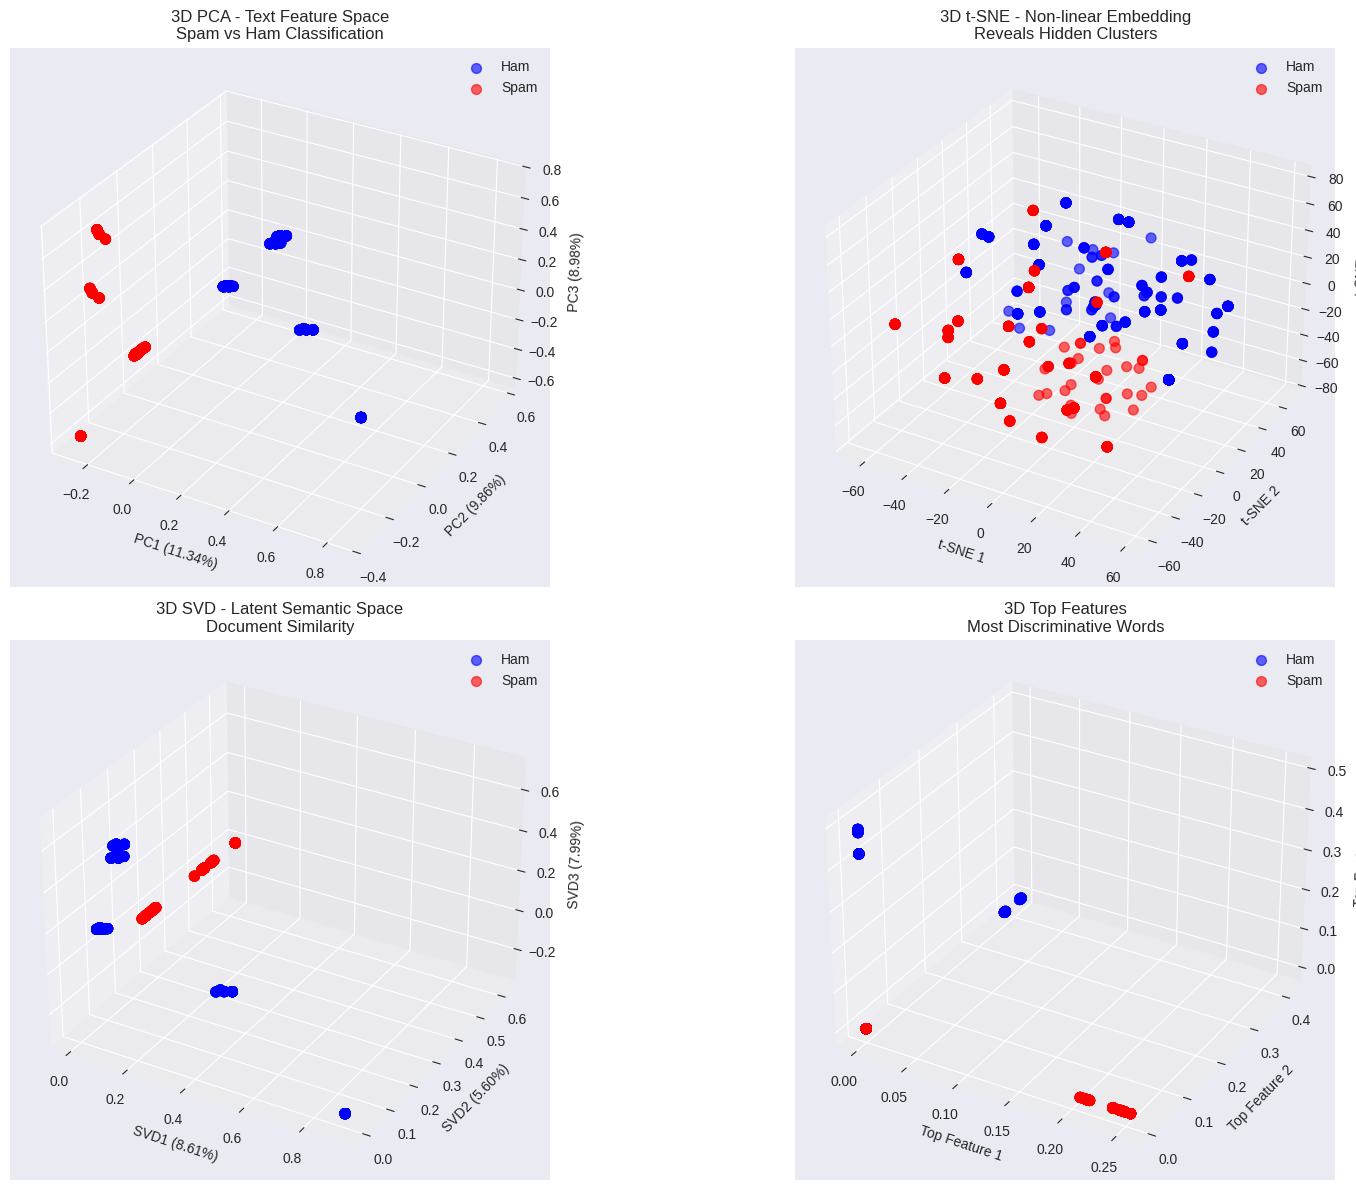

TypeError: Axes3D.bar() got multiple values for argument 'zs'

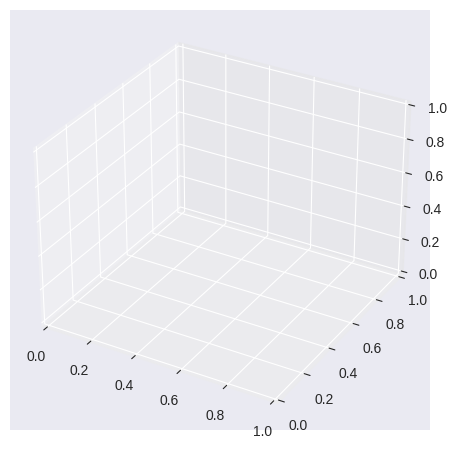

In [23]:
# ============================================================================
# 7. 🎯 EXAMPLE USAGE FUNCTIONS
# ============================================================================

# Example usage string to add to notebook:

# After training your model and vectorizing text, run:

# Make sure y is properly formatted (as numpy array or pandas series)
y = (df['label'] == 'spam').astype(int)  # Convert to 0/1 if needed

# Individual visualizations:
plot_3d_text_space(X_tfidf, y, df, sample_size=800)
create_interactive_decision_boundary(X_tfidf, y, cnb)
feature_analysis = plot_3d_probability_landscape(cnb, tfidf, top_n_features=40)

# For confusion matrix, use test predictions:
y_pred_test = cnb.predict(X_te)
y_proba_test = cnb.predict_proba(X_te)[:, 1]
plot_3d_confusion_metrics(y_te, y_pred_test, y_proba_test)

create_email_similarity_network_3d(X_tfidf, y, df, similarity_threshold=0.25)

# Or run all at once:
feature_analysis, similarity_graph = run_all_spam_detection_3d_viz(
    X_tfidf, y, df, cnb, tfidf
)

# Explore the results:
print("Top discriminative features:")
print(feature_analysis.sort_values('spam_strength', ascending=False).head(10))

print("🚀 3D Spam Detection Visualization Suite Ready!")
print("📦 Requirements: plotly, scikit-learn, networkx, wordcloud")
print("🎯 Perfect for understanding text classification in high-dimensional space!")